In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler

## Load dataset

Make sure that training and validation set end at episode.

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

In [7]:
#drop na columns 
all_df = all_df.dropna()

In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [11]:
#set random seed 
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
train_arr, trainTime = getSensorReadingsOnlyNoEpisode(train_data)
val_arr, valTime = getSensorReadingsOnlyNoEpisode(val_data)
test_arr, testTime = getSensorReadingsOnlyNoEpisode(test_data)

In [13]:
def getStateValues(lst):
    stateList = []
    for episode in lst:
        for row in episode:
            stateValue = int(row[6])
            stateList.append(stateValue)
    return stateList

In [14]:
train_states = getStateValues(train_data)
val_states = getStateValues(val_data)
test_states = getStateValues(test_data)

In [15]:
train_arr

[[0.3791510923844878,
  0.5563851872658502,
  0.2430795056854056,
  0.2295042932133039],
 [0.415506992844971,
  0.698561103062616,
  0.2424102875207293,
  0.2738245610552764],
 [0.339342049978544,
  0.6376448181414047,
  0.230266358212984,
  0.1915880980930437],
 [0.343817355746489,
  0.6277319973322149,
  0.2339045132089619,
  0.2645663491397572],
 [0.3103615567156816,
  0.6073681125184389,
  0.1942956427514773,
  0.2402001947166618],
 [0.3363276361638982,
  0.5314791420103966,
  0.215693484804905,
  0.2157803248744509],
 [0.3978311493720031,
  0.5752123900177365,
  0.1905855461472712,
  0.2305990919897332],
 [0.385974096399634,
  0.6309339533215361,
  0.2085163328904652,
  0.2476933965087503],
 [0.376943194179102,
  0.3960472833663434,
  0.2156596580713984,
  0.2569927791777754],
 [0.5649823104615325,
  0.6481979264187865,
  0.5165871513503174,
  0.2561624712284309],
 [0.3518671472356448,
  0.6477957834271194,
  0.2571618246954402,
  0.2766712183951419],
 [0.3538673534816871,
  0.615

## Approach 1: Or

As long as any feature value crosses the threshold, data point classified as anomaly

In [16]:
#define thresholds
volt_threshold = 0.4212
rotate_threshold = 0.5683
pressure_threshold = 0.283
vibration_threshold = 0.3213

In [17]:
def OrBaselineAnomalyDetector(data, volt_comparator, rotate_comparator, pressure_comparator, vibration_comparator):
    anomalyScores = [] #1 means is anomaly, 0 means not 
    for reading in data:
        if (reading[0] > volt_comparator) or (reading[1] < rotate_comparator) or (reading[2] > pressure_comparator) or (reading[3] > vibration_comparator):
            #is anomaly
            anomalyScores.append(1)
        else:
            anomalyScores.append(0)
    return anomalyScores

In [18]:
def countForStates(data):
    state0_count = 0
    state1_count = 0
    state2_count = 0
    state3_count = 0
    state8_count = 0
    state9_count = 0
    
    for item in data:
        if item == 0:
            state0_count += 1
        elif item == 1:
            state1_count += 1
        elif item == 2:
            state2_count += 1
        elif item == 3:
            state3_count += 1
        elif item == 4:
            state8_count += 1
        elif item == 5: 
            state9_count += 1
            
    return [state0_count, state1_count, state2_count, state3_count, state8_count, state9_count]

In [19]:
def processAnomaly(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order]
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain = anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal = anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest = anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.bar(x=[0,1,2,3,8,9], height = countForStates(graphData))
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train45count = train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train4percent = train4count/traintotalcount
        train5percent = train5count/traintotalcount
        train45percent = train45count/traintotalcount
        print("Percentage of anomalies identified belonging to state 4 in training set: %f" % train4percent)
        print("Percentage of anomalies identified belonging to state 5 in training set: %f" % train5percent)
        print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f \n" % train45percent)
        
        orgTrain4Count = train_states.count(4)
        orgTrain5Count = train_states.count(5)
        orgTrain45Count = orgTrain4Count + orgTrain5Count
        orgtrain4percent = train4count/orgTrain4Count
        orgtrain5percent = train5count/orgTrain5Count
        orgtrain45percent = train45count/orgTrain45Count
        print("Percentage of points in state 4 in training set identified as anomalies: %f" % orgtrain4percent)
        print("Percentage of points in state 5 in training set identified as anomalies: %f" % orgtrain5percent)
        print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f \n" % orgtrain45percent)
    elif (dataType == 'Val'): #validation set
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val45count = val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val4percent = val4count/valtotalcount
        val5percent = val5count/valtotalcount
        val45percent = val45count/valtotalcount
        print("Percentage of anomalies identified belonging to state 4 in validation set: %f" % val4percent)
        print("Percentage of anomalies identified belonging to state 5 in validation set: %f" % val5percent)
        print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)
        
        orgVal4Count = val_states.count(4)
        orgVal5Count = val_states.count(5)
        orgVal45Count = orgVal4Count + orgVal5Count
        orgVal4percent = val4count/orgVal4Count
        orgVal5percent = val5count/orgVal5Count
        orgVal45percent = val45count/orgVal45Count
        print("Percentage of points in state 4 in validation set identified as anomalies: %f" % orgVal4percent)
        print("Percentage of points in state 5 in validation set identified as anomalies: %f" % orgVal5percent)
        print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f \n" % orgVal45percent)
    elif (dataType == 'Test'): #test set
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test45count = test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test4percent = test4count/testtotalcount
        test5percent = test5count/testtotalcount
        test45percent = test45count/testtotalcount
        print("Percentage of anomalies identified belonging to state 4 in test set: %f" % test4percent)
        print("Percentage of anomalies identified belonging to state 5 in test set: %f" % test5percent)
        print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)
        
        orgTest4Count = test_states.count(4)
        orgTest5Count = test_states.count(5)
        orgTest45Count = orgTest4Count + orgTest5Count
        orgTest4percent = test4count/orgTest4Count
        orgTest5percent = test5count/orgTest5Count
        orgTest45percent = test45count/orgTest45Count
        print("Percentage of points in state 4 in test set identified as anomalies: %f" % orgTest4percent)
        print("Percentage of points in state 5 in test set identified as anomalies: %f" % orgTest5percent)
        print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f \n" % orgTest45percent)

In [20]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0,
  0.3791510923844878,
  0.5563851872658502,
  0.2430795056854056,
  0.2295042932133039,
  0.0],
 [1.0,
  0.415506992844971,
  0.698561103062616,
  0.2424102875207293,
  0.2738245610552764,
  1.0],
 [2.0,
  0.339342049978544,
  0.6376448181414047,
  0.230266358212984,
  0.1915880980930437,
  2.0],
 [3.0,
  0.343817355746489,
  0.6277319973322149,
  0.2339045132089619,
  0.2645663491397572,
  2.0],
 [4.0,
  0.3103615567156816,
  0.6073681125184389,
  0.1942956427514773,
  0.2402001947166618,
  2.0],
 [5.0,
  0.3363276361638982,
  0.5314791420103966,
  0.215693484804905,
  0.2157803248744509,
  2.0],
 [6.0,
  0.3978311493720031,
  0.5752123900177365,
  0.1905855461472712,
  0.2305990919897332,
  2.0],
 [7.0,
  0.385974096399634,
  0.6309339533215361,
  0.2085163328904652,
  0.2476933965087503,
  2.0],
 [8.0,
  0.376943194179102,
  0.3960472833663434,
  0.2156596580713984,
  0.2569927791777754,
  3.0],
 [9.0,
  0.5649823104615325,
  0.6481979264187865,
  0.5165871513503174,
  0.2561

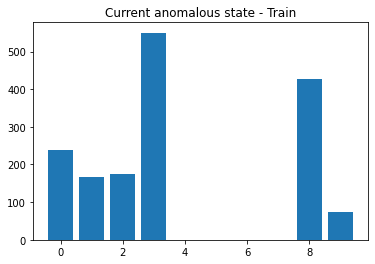

Percentage of anomalies identified belonging to state 4 in training set: 0.261963
Percentage of anomalies identified belonging to state 5 in training set: 0.045399
Percentage of anomalies identified belonging to state 4 and state 5 in training set: 0.307362 

Percentage of points in state 4 in training set identified as anomalies: 1.000000
Percentage of points in state 5 in training set identified as anomalies: 1.000000
Percentage of points in state 4 and 5 in training set identified as anomalies: 1.000000 



In [21]:
#Training Set
y_train_scores = OrBaselineAnomalyDetector(train_arr, volt_threshold, rotate_threshold, pressure_threshold, vibration_threshold)
processAnomaly(y_train_scores, train_arr, 0.5, 'Train')

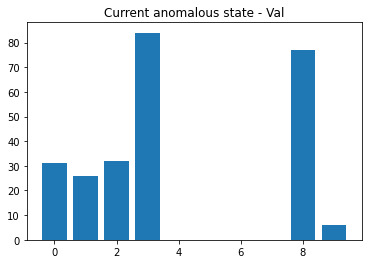

Percentage of anomalies identified belonging to state 4 in validation set: 0.300781
Percentage of anomalies identified belonging to state 5 in validation set: 0.023438
Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.324219
Percentage of points in state 4 in validation set identified as anomalies: 1.000000
Percentage of points in state 5 in validation set identified as anomalies: 1.000000
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000 



In [22]:
#Validation Set
y_val_scores = OrBaselineAnomalyDetector(val_arr, volt_threshold, rotate_threshold, pressure_threshold, vibration_threshold)
processAnomaly(y_val_scores, val_arr, 0.5, 'Val')

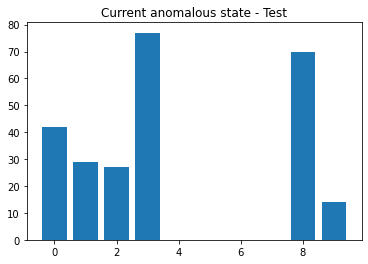

Percentage of anomalies identified belonging to state 4 in test set: 0.270270
Percentage of anomalies identified belonging to state 5 in test set: 0.054054
Percentage of anomalies identified belonging to state 4 and state 5 in test set: 0.324324
Percentage of points in state 4 in test set identified as anomalies: 1.000000
Percentage of points in state 5 in test set identified as anomalies: 1.000000
Percentage of points in state 4 and 5 in test set identified as anomalies: 1.000000 



In [23]:
#Test Set
y_test_scores = OrBaselineAnomalyDetector(test_arr, volt_threshold, rotate_threshold, pressure_threshold, vibration_threshold)
processAnomaly(y_test_scores, test_arr, 0.5, 'Test')

## Approach 2: And

Classify as anomaly if all feature values satisfy the condition

In [24]:
def AndBaselineAnomalyDetector(data, volt_comparator, rotate_comparator, pressure_comparator, vibration_comparator):
    anomalyScores = [] #1 means is anomaly, 0 means not 
    for reading in data:
        if (reading[0] > volt_comparator) and (reading[1] < rotate_comparator) and (reading[2] > pressure_comparator) and (reading[3] > vibration_comparator):
            #is anomaly
            anomalyScores.append(1)
        else:
            anomalyScores.append(0)
    return anomalyScores

In [25]:
#Training Set
y_train_scores2 = AndBaselineAnomalyDetector(train_arr, volt_threshold, rotate_threshold, pressure_threshold, vibration_threshold)
anomalyTrainCount = y_train_scores2.count(1)
print("Number of anomalies identified: %d" % anomalyTrainCount)

Number of anomalies identified: 0


In [26]:
#Validation Set
y_val_scores2 = AndBaselineAnomalyDetector(val_arr, volt_threshold, rotate_threshold, pressure_threshold, vibration_threshold)
anomalyValCount = y_val_scores2.count(1)
print("Number of anomalies identified: %d" % anomalyValCount)

Number of anomalies identified: 0


In [27]:
#Test Set
y_test_scores2 = AndBaselineAnomalyDetector(test_arr, volt_threshold, rotate_threshold, pressure_threshold, vibration_threshold)
anomalyTestCount = y_test_scores2.count(1)
print("Number of anomalies identified: %d" % anomalyTestCount)

Number of anomalies identified: 0


No anomalies identified by the second approach.

## Approach 3: Probabilistic (Equal Probability)

In [28]:
def EqualProbabilityAnomalyDetector(data):
    anomalyScores = [] #1 means is anomaly, 0 means not 
    for reading in data:
        randomNum = random.randint(0,1)
        if randomNum:
            #is anomaly
            anomalyScores.append(1)
        else:
            anomalyScores.append(0)
    return anomalyScores

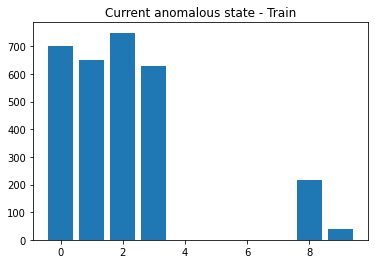

Percentage of anomalies identified belonging to state 4 in training set: 0.073032
Percentage of anomalies identified belonging to state 5 in training set: 0.013065
Percentage of anomalies identified belonging to state 4 and state 5 in training set: 0.086097 

Percentage of points in state 4 in training set identified as anomalies: 0.510539
Percentage of points in state 5 in training set identified as anomalies: 0.527027
Percentage of points in state 4 and 5 in training set identified as anomalies: 0.512974 



In [29]:
import random
#Training Set
y_train_scores3 = EqualProbabilityAnomalyDetector(train_arr)
processAnomaly(y_train_scores3, train_arr, 0.5, 'Train')

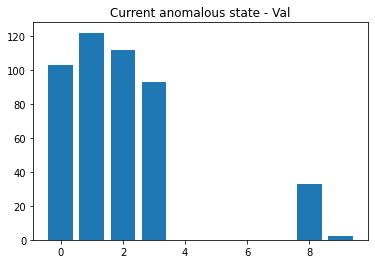

Percentage of anomalies identified belonging to state 4 in validation set: 0.070968
Percentage of anomalies identified belonging to state 5 in validation set: 0.004301
Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.075269
Percentage of points in state 4 in validation set identified as anomalies: 0.428571
Percentage of points in state 5 in validation set identified as anomalies: 0.333333
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.421687 



In [30]:
#Validation Set
y_val_scores3 = EqualProbabilityAnomalyDetector(val_arr)
processAnomaly(y_val_scores3, val_arr, 0.5, 'Val')

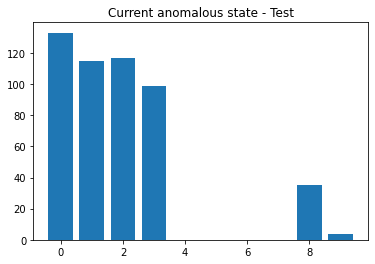

Percentage of anomalies identified belonging to state 4 in test set: 0.069583
Percentage of anomalies identified belonging to state 5 in test set: 0.007952
Percentage of anomalies identified belonging to state 4 and state 5 in test set: 0.077535
Percentage of points in state 4 in test set identified as anomalies: 0.500000
Percentage of points in state 5 in test set identified as anomalies: 0.285714
Percentage of points in state 4 and 5 in test set identified as anomalies: 0.464286 



In [31]:
#Test Set
y_test_scores3 = EqualProbabilityAnomalyDetector(test_arr)
processAnomaly(y_test_scores3, test_arr, 0.5, 'Test')

## Approach 4: Probability based on Failure Rate

Failure rate is around 0.08

In [32]:
def FailureProbabilityAnomalyDetector(data):
    anomalyScores = [] #1 means is anomaly, 0 means not 
    for reading in data:
        randomNum = random.randint(1,100)
        if randomNum < 9:
            #is anomaly
            anomalyScores.append(1)
        else:
            anomalyScores.append(0)
    return anomalyScores

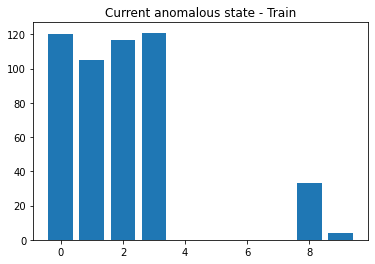

Percentage of anomalies identified belonging to state 4 in training set: 0.066000
Percentage of anomalies identified belonging to state 5 in training set: 0.008000
Percentage of anomalies identified belonging to state 4 and state 5 in training set: 0.074000 

Percentage of points in state 4 in training set identified as anomalies: 0.077283
Percentage of points in state 5 in training set identified as anomalies: 0.054054
Percentage of points in state 4 and 5 in training set identified as anomalies: 0.073852 



In [33]:
#Training Set
y_train_scores4 = FailureProbabilityAnomalyDetector(train_arr)
processAnomaly(y_train_scores4, train_arr, 0.5, 'Train')

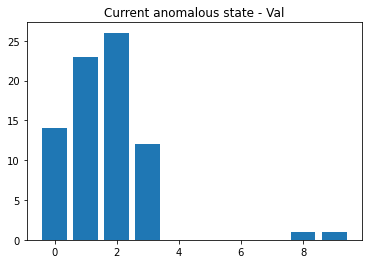

Percentage of anomalies identified belonging to state 4 in validation set: 0.012987
Percentage of anomalies identified belonging to state 5 in validation set: 0.012987
Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.025974
Percentage of points in state 4 in validation set identified as anomalies: 0.012987
Percentage of points in state 5 in validation set identified as anomalies: 0.166667
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.024096 



In [34]:
#Validation Set
y_val_scores4 = FailureProbabilityAnomalyDetector(val_arr)
processAnomaly(y_val_scores4, val_arr, 0.5, 'Val')

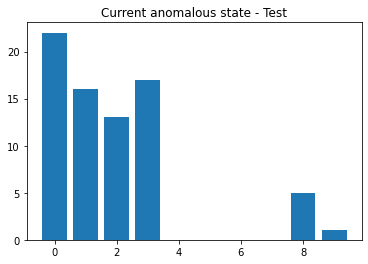

Percentage of anomalies identified belonging to state 4 in test set: 0.067568
Percentage of anomalies identified belonging to state 5 in test set: 0.013514
Percentage of anomalies identified belonging to state 4 and state 5 in test set: 0.081081
Percentage of points in state 4 in test set identified as anomalies: 0.071429
Percentage of points in state 5 in test set identified as anomalies: 0.071429
Percentage of points in state 4 and 5 in test set identified as anomalies: 0.071429 



In [35]:
#Test Set
y_test_scores4 = FailureProbabilityAnomalyDetector(test_arr)
processAnomaly(y_test_scores4, test_arr, 0.5, 'Test')